In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn modules
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB 

# Evaluation metrics
from sklearn.metrics import (
    precision_score, recall_score, f1_score, classification_report, 
    confusion_matrix, accuracy_score, roc_curve, auc, make_scorer
)


### Data preparation

In [2]:
# Load the dataset
data = pd.read_excel("D:/Eimeria_Classification_TFG/Eimeria_Classification_TFG/data/reference_data.xlsx")

# Display the first few rows
print("Head of the dataset:")
print(data.head())

# Get a summary of the dataset (data types, non-null counts, etc.)
print("\nDataset info:")
print(data.info())

# Descriptive statistics for numerical features
print("\nDescriptive statistics:")
print(data.describe())

# Summary
total = len(data)
print(f"Total number of observations: {total}")

# Print number of samples per species
species_counts = data['Species'].value_counts()
print("\nNumber of observations per species:")
print(species_counts)


Head of the dataset:
      Species     Length      Width
0  Adenoeides  23.446152  17.030811
1  Adenoeides  22.451702  15.288264
2  Adenoeides  25.447579  16.636300
3  Adenoeides  19.580408  15.876789
4  Adenoeides  19.744849  16.034071

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 470 entries, 0 to 469
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Species  470 non-null    object 
 1   Length   470 non-null    float64
 2   Width    470 non-null    float64
dtypes: float64(2), object(1)
memory usage: 11.1+ KB
None

Descriptive statistics:
           Length       Width
count  470.000000  470.000000
mean    23.477110   19.234293
std      3.474809    2.561986
min     14.296048   13.305729
25%     20.723700   17.315603
50%     23.580369   18.800385
75%     26.251135   21.243773
max     31.427892   25.525573
Total number of observations: 470

Number of observations per species:
Species
Dispersa         140
M

In [3]:
# Check for missing values in each column
print(data.isnull().sum())

Species    0
Length     0
Width      0
dtype: int64


In [4]:
# Check for duplicate rows
duplicate_count = data.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")

# Remove duplicate rows if necessary
data = data.drop_duplicates()

Number of duplicate rows: 0


### Exploratory Data Analysis (EDA)

C:\Users\apf6226\AppData\Local\Temp\ipykernel_25200\1880900648.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Species', data=data, palette="muted")


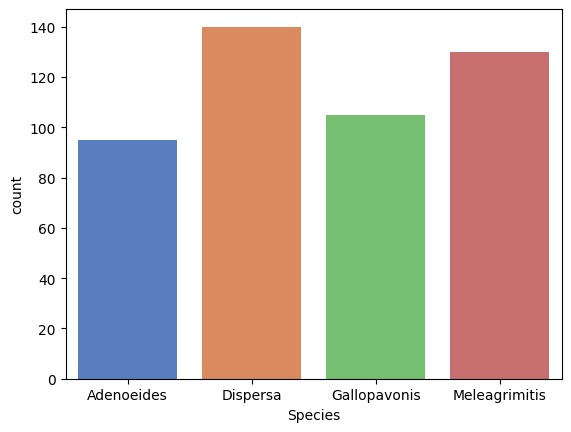

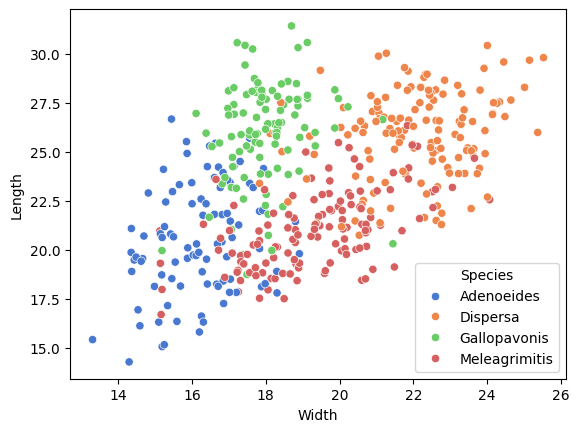

In [5]:
# Visualize the distribution of classes
sns.countplot(x='Species', data=data, palette="muted")
plt.show()

# Scatter plot for Length and Width
sns.scatterplot(x='Width', y='Length', hue='Species', data=data, palette="muted")
plt.show()

Text(0, 0.5, 'Frequency')

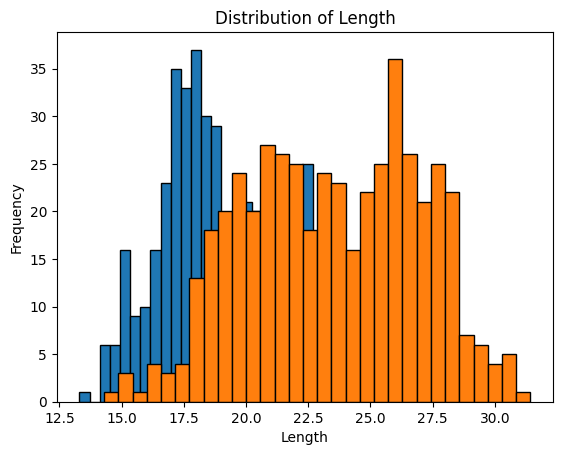

In [6]:
# Histogram for 'Width'
plt.hist(data['Width'], bins=30, edgecolor='black')
plt.title('Distribution of Width')
plt.xlabel('Width')
plt.ylabel('Frequency')
#plt.show()

# Histogram for 'Length'
plt.hist(data['Length'], bins=30, edgecolor='black')
plt.title('Distribution of Length')
plt.xlabel('Length')
plt.ylabel('Frequency')
#plt.show()


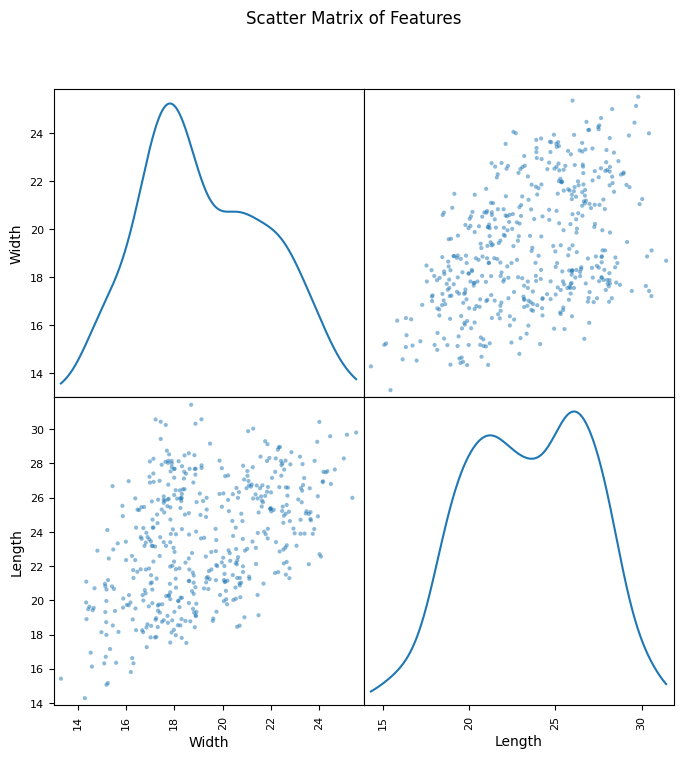

In [7]:
# Scatter matrix for numeric features
pd.plotting.scatter_matrix(data[['Width', 'Length']], figsize=(8, 8), diagonal='kde')
plt.suptitle('Scatter Matrix of Features')
plt.show()


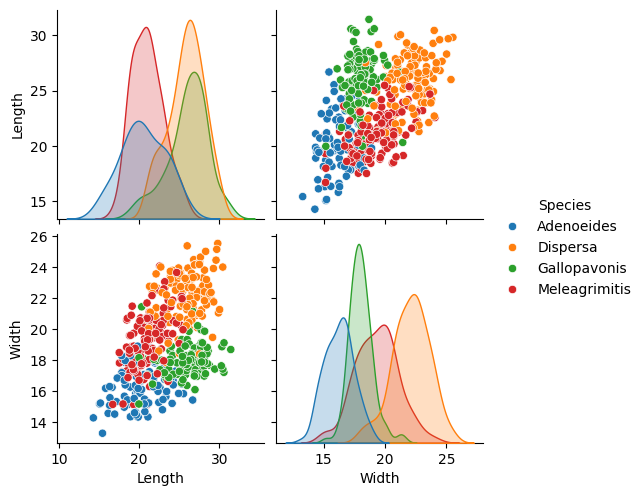

In [8]:
# Pairplot to analyze variable relationships
sns.pairplot(data, hue='Species')

### Split the dataset

In [9]:
X = data[['Width', 'Length']].values  # convert to np.array
y = data['Species'].values            # convert to np.array

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# Stratified splitting (stratify=y) is good because it ensures balanced class distribution

In [10]:
# Standardize features
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

In [11]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to balance classes in training set
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_std, y_train)

# Keep test set unchanged
X_test_smote = X_test_std  
y_test_smote = y_test


### Choose and Train Classification Algorithms

In [12]:

def mean_class_accuracy(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    per_class_acc = cm.diagonal() / cm.sum(axis=1)
    return np.mean(per_class_acc)


def evaluate_models(X_train, X_test, y_train, y_test, label=""):
    models = { 
        "Logistic Regression": LogisticRegression(multi_class='ovr', max_iter=1000, random_state=24),
        "Decision Tree": DecisionTreeClassifier(random_state=24),
        "Random Forest": RandomForestClassifier(random_state=24),
        "SVM": SVC(random_state=24),  
        "Naïve Bayes": GaussianNB(),  
        "KNN": KNeighborsClassifier() 
    }

    results = {}
    kf = KFold(n_splits=5, shuffle=True, random_state=24)
    
    for name, model in models.items():
        print(f"\nTraining {name} on {label} data...")

        mean_class_accuracies = []

        for train_idx, val_idx in kf.split(X_train):
            X_cv_train, X_cv_val = X_train[train_idx], X_train[val_idx]
            y_cv_train, y_cv_val = y_train[train_idx], y_train[val_idx]

            model.fit(X_cv_train, y_cv_train)
            y_cv_pred = model.predict(X_cv_val)

            mca = mean_class_accuracy(y_cv_val, y_cv_pred)
            mean_class_accuracies.append(mca)

        avg_mean_class_acc = np.mean(mean_class_accuracies)
        std_mean_class_acc = np.std(mean_class_accuracies)

        # Train model
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Metrics
        test_accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

        results[name] = {
            'Test Accuracy': test_accuracy, 
            'CV Mean Class Accuracy': avg_mean_class_acc,
            'CV Mean Class Accuracy Std': std_mean_class_acc,
            'Precision': precision,
            'Recall': recall,
            'F1-score': f1
        }

    # Summary DataFrame
    summary_df = pd.DataFrame.from_dict(results, orient='index')
    summary_df.reset_index(inplace=True)
    summary_df.rename(columns={
        'index': 'Model', 
        'Test Accuracy': 'Test Accuracy (%)', 
        'CV Mean Class Accuracy': 'CV Mean Class Accuracy (%)',
        'CV Mean Class Accuracy Std': 'CV Mean Class Accuracy Std (%)',
        'Precision': 'Precision (%)',
        'Recall': 'Recall (%)',
        'F1-score': 'F1-score (%)'
    }, inplace=True)

    # Convert to percentages
    for col in ['Test Accuracy (%)', 'CV Mean Class Accuracy (%)', 'CV Mean Class Accuracy Std (%)', 
            'Precision (%)', 'Recall (%)', 'F1-score (%)']:

        summary_df[col] = (summary_df[col] * 100).round(2)

    

    print(f"\nModel Evaluation Summary for {label} data:")
    print(summary_df.to_string(index=False))

    # Display table as a figure (optional)
    fig, ax = plt.subplots(figsize=(12, len(summary_df) * 0.5 + 1))
    ax.axis('off')
    table = ax.table(
        cellText=summary_df.values,
        colLabels=summary_df.columns,
        cellLoc='center',
        loc='center'
    )
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.2)
    plt.title(f"Model Evaluation Summary for {label} data", fontsize=14)
    plt.show()

    return summary_df



Training Logistic Regression on Raw data...


C:\Users\apf6226\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\apf6226\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\apf6226\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' 


Training Decision Tree on Raw data...

Training Random Forest on Raw data...

Training SVM on Raw data...

Training Naïve Bayes on Raw data...

Training KNN on Raw data...

Model Evaluation Summary for Raw data:
              Model  Test Accuracy (%)  CV Mean Class Accuracy (%)  CV Mean Class Accuracy Std (%)  Precision (%)  Recall (%)  F1-score (%)
Logistic Regression              79.79                       76.16                            4.39          80.01       79.79         79.84
      Decision Tree              67.02                       68.80                            3.70          66.62       67.02         66.44
      Random Forest              78.72                       73.39                            2.35          79.13       78.72         78.83
                SVM              80.85                       76.36                            4.21          80.96       80.85         80.85
        Naïve Bayes              80.85                       75.73                     

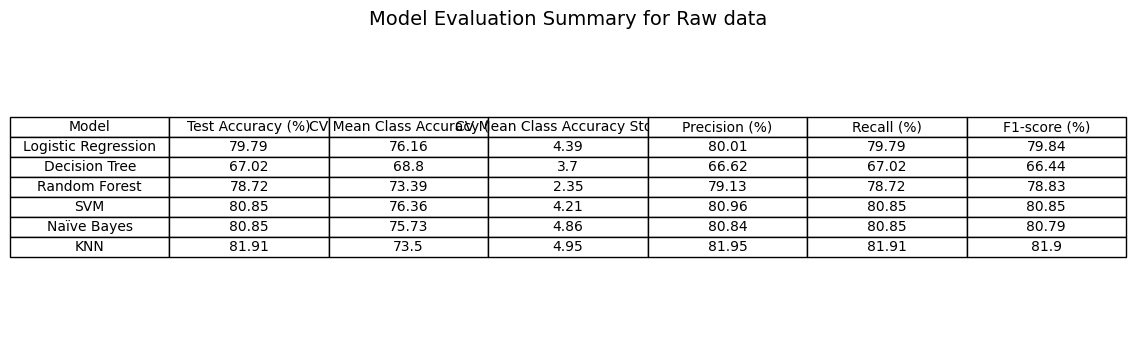


Training Logistic Regression on Standardized data...

Training Decision Tree on Standardized data...

Training Random Forest on Standardized data...


C:\Users\apf6226\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\apf6226\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\apf6226\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' 


Training SVM on Standardized data...

Training Naïve Bayes on Standardized data...

Training KNN on Standardized data...

Model Evaluation Summary for Standardized data:
              Model  Test Accuracy (%)  CV Mean Class Accuracy (%)  CV Mean Class Accuracy Std (%)  Precision (%)  Recall (%)  F1-score (%)
Logistic Regression              78.72                       76.18                            4.96          79.02       78.72         78.77
      Decision Tree              67.02                       68.80                            3.70          66.62       67.02         66.44
      Random Forest              78.72                       73.39                            2.35          79.13       78.72         78.83
                SVM              81.91                       77.40                            4.18          81.94       81.91         81.87
        Naïve Bayes              80.85                       75.73                            4.86          80.84       80.85    

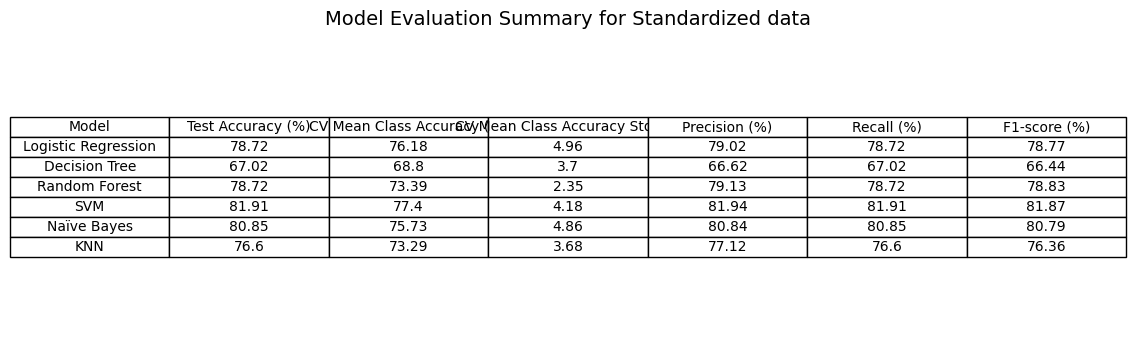


Training Logistic Regression on SMOTEd data...

Training Decision Tree on SMOTEd data...

Training Random Forest on SMOTEd data...


C:\Users\apf6226\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\apf6226\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\apf6226\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' 


Training SVM on SMOTEd data...

Training Naïve Bayes on SMOTEd data...

Training KNN on SMOTEd data...

Model Evaluation Summary for SMOTEd data:
              Model  Test Accuracy (%)  CV Mean Class Accuracy (%)  CV Mean Class Accuracy Std (%)  Precision (%)  Recall (%)  F1-score (%)
Logistic Regression              79.79                       77.00                            4.57          80.21       79.79         79.68
      Decision Tree              67.02                       71.85                            3.88          66.58       67.02         66.21
      Random Forest              76.60                       78.42                            2.61          76.92       76.60         76.66
                SVM              80.85                       79.41                            3.27          81.01       80.85         80.70
        Naïve Bayes              81.91                       77.92                            4.51          82.12       81.91         81.83
             

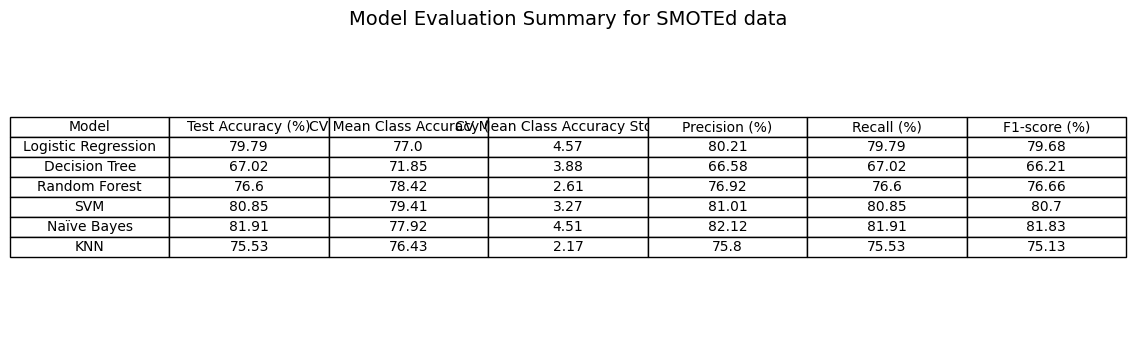

,Model,Test Accuracy (%),CV Mean Class Accuracy (%),CV Mean Class Accuracy Std (%),Precision (%),Recall (%),F1-score (%)
0,Logistic Regression,79.79,77.00,4.57,80.21,79.79,79.68
1,Decision Tree,67.02,71.85,3.88,66.58,67.02,66.21
2,Random Forest,76.60,78.42,2.61,76.92,76.60,76.66
3,SVM,80.85,79.41,3.27,81.01,80.85,80.70
4,Naïve Bayes,81.91,77.92,4.51,82.12,81.91,81.83
5,KNN,75.53,76.43,2.17,75.80,75.53,75.13


In [13]:
# RAW
evaluate_models(X_train, X_test, y_train, y_test, label="Raw")

# STANDARDIZED
evaluate_models(X_train_std, X_test_std, y_train, y_test, label="Standardized")

# SMOTED
evaluate_models(X_train_smote, X_test_std, y_train_smote, y_test_smote, label="SMOTEd")


### Model Tunning

SMOTEd: SVM

In [14]:
# Define the SVM parameter grid
param_grid_svm = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 0.01, 0.1, 1],
    'kernel': ['rbf', 'linear']
}

# Create the custom scorer
mean_class_accuracy_scorer = make_scorer(mean_class_accuracy)

grid_search_svm_smote = GridSearchCV(
    estimator=SVC(probability=True),
    param_grid=param_grid_svm,
    cv=5,
    scoring=mean_class_accuracy_scorer,
    n_jobs=-1,
    verbose=1
)

grid_search_svm_smote.fit(X_train_smote, y_train_smote)

print("Best SVM Parameters (SMOTEd):", grid_search_svm_smote.best_params_)
print("Best CV Mean Class Accuracy (SMOTEd):", round(grid_search_svm_smote.best_score_ * 100, 2), "%")


Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best SVM Parameters (SMOTEd): {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
Best CV Mean Class Accuracy (SMOTEd): 79.86 %


Classification Report after Tuning:
               precision    recall  f1-score   support

   Adenoeides       0.79      1.00      0.88        19
     Dispersa       0.88      0.79      0.83        28
 Gallopavonis       0.89      0.81      0.85        21
Meleagrimitis       0.81      0.81      0.81        26

     accuracy                           0.84        94
    macro avg       0.84      0.85      0.84        94
 weighted avg       0.85      0.84      0.84        94

Confusion Matrix after Tuning:


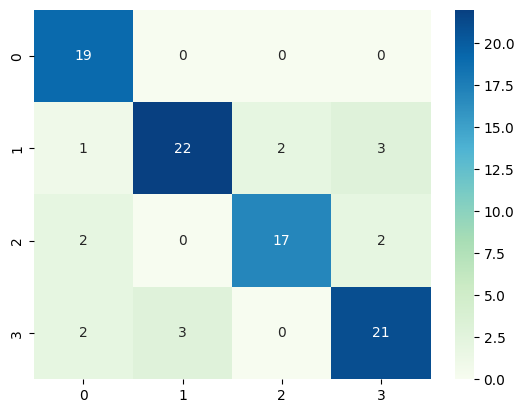

Accuracy Score after Tuning: 0.8404255319148937


In [15]:
# Get best model from grid search
best_model = grid_search_svm_smote.best_estimator_

# Make predictions using the best model found in GridSearchCV
y_best_pred = best_model.predict(X_test_smote)

print("Classification Report after Tuning:")
print(classification_report(y_test_smote, y_best_pred))

print("Confusion Matrix after Tuning:")
conf_matrix_best = confusion_matrix(y_test_smote, y_best_pred)
sns.heatmap(conf_matrix_best, annot=True, fmt='d', cmap='GnBu')
#plt.title(f'SVM Confusion Matrix After Tuning')
plt.show()

print("Accuracy Score after Tuning:", accuracy_score(y_test_smote, y_best_pred))


Raw: Logistic Regression

In [16]:
# Define parameter grid
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['liblinear', 'lbfgs']
}

grid_search_lr = GridSearchCV(
    estimator=LogisticRegression(max_iter=1000, multi_class='ovr', random_state=24),
    param_grid=param_grid_lr,
    cv=5,
    scoring=mean_class_accuracy_scorer,
    n_jobs=-1,
    verbose=1
)

grid_search_lr.fit(X_train, y_train)

print("Best Logistic Regression Parameters:", grid_search_lr.best_params_)
print("Best CV Mean Class Accuracy (Raw):", round(grid_search_lr.best_score_ * 100, 2), "%")


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Logistic Regression Parameters: {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
Best CV Mean Class Accuracy (Raw): 76.17 %


C:\Users\apf6226\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Standarized: SVM

In [17]:


# Set up GridSearchCV using F1-score
grid_search_svm_std = GridSearchCV(
    estimator=SVC(probability=True),
    param_grid=param_grid_svm,
    cv=5,
    scoring=mean_class_accuracy_scorer,
    n_jobs=-1,
    verbose=1
)

# Fit the model
grid_search_svm_std.fit(X_train_std, y_train)

# Output results
print("Best Parameters:", grid_search_svm_std.best_params_)
print("Best CV Mean Class Accuracy (Std):", round(grid_search_svm_std.best_score_ * 100, 2), "%")



Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best CV Mean Class Accuracy (Std): 79.45 %


### Save the best model

In [18]:
import joblib

joblib.dump(best_model, "best_model_tfg.pkl")

['best_model_tfg.pkl']

### Model Evaluation

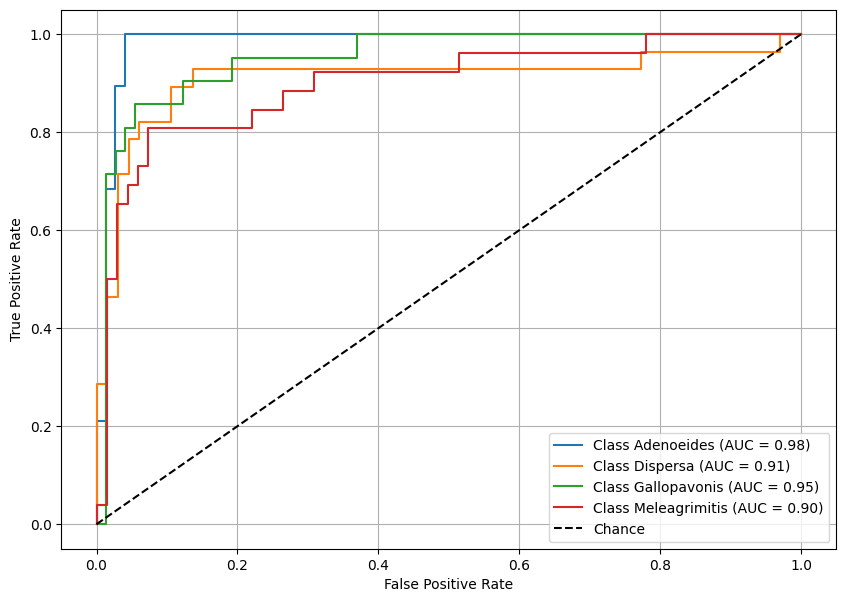

In [19]:
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier


# Binarize the output for ROC (multiclass)
classes = np.unique(y_test_smote)
y_test_bin = label_binarize(y_test_smote, classes=classes)
n_classes = y_test_bin.shape[1]

# Fit OneVsRest model (use best_model from GridSearch)
classifier = OneVsRestClassifier(best_model)
classifier.fit(X_train_smote, y_train_smote)
y_score = classifier.predict_proba(X_test_smote)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 7))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {classes[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('Multiclass ROC Curve (SVM)')
plt.legend()
plt.grid(True)
plt.show()